In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# 检查 GPU 是否可用
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available


In [3]:
'''
生成天气数据： 使用正弦函数模拟温度和湿度的周期性变化，并添加随机噪声。使用随机数生成风速数据。
添加天气数据到 DataFrame： 将生成的天气数据添加到 load_data 中。
生成日历数据： 使用 time_index.weekday 获取每个时间点对应的星期几，然后判断是否为周末，并假设没有节假日。
添加日历数据到 DataFrame： 将生成的日历数据添加到 load_data 中。
'''


#创建模拟数据集
np.random.seed(42)  # 设置随机种子，保证结果可复现

# 时间维度：一周7天，每天96个时间点（每15分钟一个）
time_index = pd.date_range(start='2024-01-01', end='2024-07-31 23:45', freq='15min')

# 空间维度：假设有3个变电站
# substations = ['A', 'B', 'C']




load_data = pd.DataFrame(index=time_index)
# 添加日历数据
load_data['Weekday'] = time_index.weekday  # 0: Monday, 1: Tuesday, ..., 6: Sunday
load_data['IsWeekend'] = load_data['Weekday'].isin([5, 6]).astype(int)  # 1: Weekend, 0: Weekday

# 添加天气数据
temperature = 20 + 10 * np.sin(2 * np.pi * (np.arange(len(time_index))-32) / 96) + np.random.rand(len(time_index)) * 5
humidity = 50 + 20 * np.sin(2 * np.pi * np.arange(len(time_index)) / 96) + np.random.rand(len(time_index)) * 10
wind_speed = 5 + 3 * np.random.rand(len(time_index))

load_data['Temperature'] = temperature
load_data['Humidity'] = humidity
load_data['WindSpeed'] = wind_speed
#load_data['IsHoliday'] = 0  # 假设没有节假日

# 模拟负荷数据：
# - 基本负荷：每个变电站有一个基本负荷值，在一天内波动
# - 随机噪声：添加随机噪声，模拟实际负荷的波动
#base_loads = {'A': 100, 'B': 150, 'C': 200}

base_loads =  200 + np.random.uniform(0.9,1.1) * 50 * np.abs(load_data['Temperature']-20)/15   # 每天的波动范围为0-50, 与温度有关
work_hours_variations = np.array([max(0,np.sin(np.pi * (i % 96-32) / 32))*200 for i in range(len(time_index))])*np.random.uniform(0.9,1.1,len(time_index)) *(1+np.abs((load_data['Humidity']-50)/240)) # 工作时间段的波动范围为0-100
noise = np.random.rand(len(time_index)) * 50  # 随机噪声
load_data['base_loads'] = base_loads + noise
load_data["work_hours"] = work_hours_variations
load_data["real_load"] = load_data["work_hours"] * (1-load_data["IsWeekend"])+ load_data['base_loads']


print(load_data.head())


                     Weekday  IsWeekend  Temperature   Humidity  WindSpeed  \
2024-01-01 00:00:00        0          0    13.212447  55.088214   7.952458   
2024-01-01 00:15:00        0          0    15.784844  60.527021   7.907493   
2024-01-01 00:30:00        0          0    14.421174  61.206200   7.741282   
2024-01-01 00:45:00        0          0    13.523991  63.589341   6.305941   
2024-01-01 01:00:00        0          0    11.120835  61.681172   5.500009   

                     base_loads  work_hours   real_load  
2024-01-01 00:00:00  244.721562         0.0  244.721562  
2024-01-01 00:15:00  225.573837         0.0  225.573837  
2024-01-01 00:30:00  265.233671         0.0  265.233671  
2024-01-01 00:45:00  262.074133         0.0  262.074133  
2024-01-01 01:00:00  277.203636         0.0  277.203636  


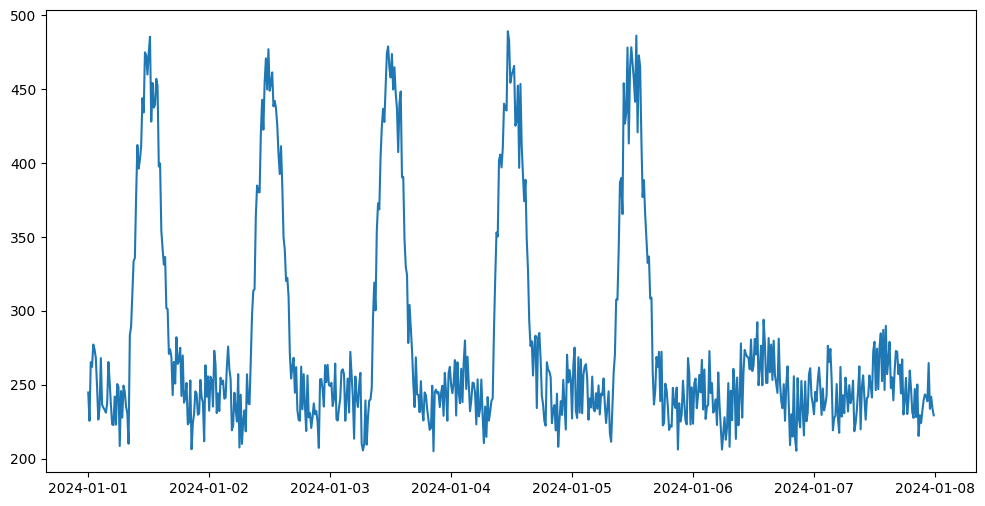

In [4]:
plt_data = load_data[:96*7]
fig = plt.figure(figsize=(12, 6))
plt.plot(plt_data.index, plt_data['real_load'], label='Real Load')

In [5]:
# 数据预处理
scaler = MinMaxScaler()  # 使用 MinMaxScaler 进行特征缩放
load_data[['real_load', 'Temperature', 'Humidity']] = scaler.fit_transform(load_data[['real_load', 'Temperature', 'Humidity']])

# 缺失值处理（如果需要）
load_data.fillna(method='ffill', inplace=True)  # 使用前一个值填充缺失值

# 特征选择
input_cols = ['real_load','IsWeekend','Temperature','Humidity',]
# input_cols = ['real_load','IsWeekend']

# 创建输入输出序列
def create_sequences(data, seq_length, target_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_length):
        x = data[i:(i + seq_length)].values
        y = data['real_load'][(i + seq_length):(i + seq_length + target_length)].values
        # y = data.loc[(i + seq_length):(i + seq_length + target_length), 'real_load'].values
        if i == 0:
            print(x.shape, y.shape)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 96*7   # 使用前七天的数据作为输入
target_length =1

X, y = create_sequences(load_data[input_cols], seq_length, target_length)
print(X.shape, y.shape)
# 划分训练集和验证集
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# 构建 DataLoader
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

for i, batch in enumerate(val_loader):
    if i == 0:
        inputs, labels = batch
        print(labels[0])
        print(inputs[0])
        print(inputs.shape, labels.shape)


(672, 4) (1,)
(19775, 672, 4) (19775, 1)
tensor([0.0910])
tensor([[0.1332, 0.0000, 0.5170, 0.1237],
        [0.1123, 0.0000, 0.6515, 0.1327],
        [0.0771, 0.0000, 0.6106, 0.1810],
        ...,
        [0.1440, 0.0000, 0.6372, 0.0773],
        [0.1713, 0.0000, 0.5590, 0.1274],
        [0.0935, 0.0000, 0.5615, 0.0715]])
torch.Size([256, 672, 4]) torch.Size([256, 1])


In [6]:
class ForecastingEncoderDecoder(nn.Module):
    def __init__(self, num_features, num_hiddens, num_layers, output_dim, num_steps,
                 encoder_bi = False,dropout=0, weight_init_type='xavier_uniform'):
        super().__init__()
        self.num_layers = num_layers
        self.encoder = nn.GRU(input_size = num_features, hidden_size = num_hiddens, num_layers = self.num_layers,
                      batch_first=False, bidirectional =encoder_bi, dropout=dropout)
        self.num_direc = 2 if encoder_bi == True else 1
        self.decoder = nn.GRU(
            num_features + num_hiddens * self.num_direc, num_hiddens, self.num_layers,
            dropout=dropout)
        self.dense1 = nn.Linear(num_hiddens,1)
        self.dense2 = nn.Linear(num_steps,output_dim)
        self.activ = nn.Sigmoid()
        # Weight Initialization Strategies
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if weight_init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                elif weight_init_type == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                elif weight_init_type == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight)
                elif weight_init_type == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight)
                else:
                    raise ValueError(f"Unknown weight initialization type: {weight_init_type}")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

    def init_state(self, enc_outputs):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        output, hidden_state = enc_outputs
        return (output, hidden_state)

    def forward(self, X):
        # Shape of enc_out: (num_steps, batch_size, num_hiddens), (num_layers, batch_size, num_hiddens)
        enc_out= self.encoder(X)
        # print('encoder output shape',enc_out[0].shape, enc_out[1].shape)

        # Shape of state: (batch_size, num_steps, num_hiddens), (num_layers, batch_size, num_hiddens)
        state = self.init_state(enc_out)
        # print('initial state.shape',state[0].shape, state[1].shape)

        # Shape of enc_output: (num_steps, batch_size, num_hiddens)
        # Shape of hidden sttate: (num_layers, batch_size, num_hiddens)
        enc_output, hidden_state = state
        hidden_state = hidden_state[:self.num_layers]
        # print('enc_output.shape',enc_output.shape)
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(X.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((X, context), -1)
        # outputs shape: (batch_size, num_steps, output_dim)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = self.decoder(embs_and_context, hidden_state)
        outputs = self.dense1(outputs).permute(1, 0, 2)
        outputs = self.activ(self.dense2(outputs.squeeze(-1)))

        return outputs, [enc_output, hidden_state]
    
    def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

In [9]:
# num_features = 2  # 输入特征维度
# num_hiddens = 32  # 隐藏层维度
# num_layers = 10  # GRU 层数
# output_dim = 1  # 输出维度（与输入维度相同）
# batch_size = 256
# seq_length = 96*7

# model_example = ForecastingEncoderDecoder(num_features=num_features, num_hiddens=num_hiddens, num_layers=num_layers, output_dim= output_dim, num_steps=seq_length, encoder_bi=True, dropout=0).to(device)

# data = torch.randn(seq_length, batch_size,  num_features).to(device)
# target = torch.randn(batch_size, output_dim).to(device)
# output, state = model_example(data)  # teacher_forcing_ratio 可调
# print(output.shape, target.shape)


torch.Size([256, 1]) torch.Size([256, 1])


In [8]:
criterion = nn.MSELoss()  # 使用均方误差作为损失函数

num_features = 4  # 输入特征维度
hidden_dims = 128  # 隐藏层维度
num_layers = 3  # GRU 层数
output_dim = 1  # 输出维度（与输入维度相同）
batch_size = 256
seq_length = 96*7

# writer = SummaryWriter('./logs/BiGRUEncoderDecoder')

model = ForecastingEncoderDecoder(num_features=num_features, num_hiddens= hidden_dims, num_layers=num_layers, 
                                  output_dim=output_dim, num_steps = seq_length, encoder_bi=True,
                                 weight_init_type='xavier_normal', dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)  # 使用 Adam 优化器



num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    outputs, targets = [], []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        data = data.permute(1, 0, 2)
        target = target.to(device)
        # target = target.unsqueeze(-1)
        # print('data.shape',data.shape)
        # print('target.shape',target.shape)

        optimizer.zero_grad()
        output, state = model(data) 

        # output = output.permute(1, 0, 2)
        # print('Output shape:', output.shape)
        # print('Target shape:', target.shape)
        # if batch_idx == len(train_loader)-1:
        #     print(f"Output at final batch:", output)
        loss = criterion(output, target)
        loss.backward()
        outputs.append(output.cpu().detach().numpy())
        targets.append(target.cpu().detach().numpy())
        # if batch_idx == len(train_loader)-1:
        #     for name, param in model.named_parameters():
        #         print(f"Name: {name}, Shape: {param.shape}, Gradient Required: {param.requires_grad}",'Gradiant is not None:', param.grad != None)
        #     print(f" Output Gradient at {batch_idx} batch:", output.grad)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()

        # # 记录标量值（如loss）
        # writer.add_scalar('Loss/train', loss.item(), epoch)

        # # 记录模型结构
        # writer.add_graph(model, input_to_model)

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

    # 在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data, target in val_loader:
            data = data.to(device)
            data = data.permute(1, 0, 2)
            target = target.to(device)

            output, state = model(data) 
            loss = criterion(output, target)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

Epoch 1/30, Loss: 0.0138
Validation Loss: 0.0037
Epoch 2/30, Loss: 0.0038
Validation Loss: 0.0035
Epoch 3/30, Loss: 0.0037
Validation Loss: 0.0037
Epoch 4/30, Loss: 0.0035
Validation Loss: 0.0036
Epoch 5/30, Loss: 0.0034
Validation Loss: 0.0034
Epoch 6/30, Loss: 0.0035
Validation Loss: 0.0035
Epoch 7/30, Loss: 0.0033
Validation Loss: 0.0031
Epoch 8/30, Loss: 0.0030
Validation Loss: 0.0028
Epoch 9/30, Loss: 0.0029
Validation Loss: 0.0029
Epoch 10/30, Loss: 0.0030
Validation Loss: 0.0028
Epoch 11/30, Loss: 0.0030
Validation Loss: 0.0028
Epoch 12/30, Loss: 0.0029
Validation Loss: 0.0029
Epoch 13/30, Loss: 0.0028
Validation Loss: 0.0027
Epoch 14/30, Loss: 0.0028
Validation Loss: 0.0027
Epoch 15/30, Loss: 0.0028
Validation Loss: 0.0027
Epoch 16/30, Loss: 0.0028
Validation Loss: 0.0026
Epoch 17/30, Loss: 0.0028
Validation Loss: 0.0029
Epoch 18/30, Loss: 0.0028
Validation Loss: 0.0026
Epoch 19/30, Loss: 0.0028
Validation Loss: 0.0026
Epoch 20/30, Loss: 0.0027
Validation Loss: 0.0026
Epoch 21/

In [10]:
# 在验证集上进行预测
model.eval()
predictions = []
actual_values = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        # if i == 1:
        # print(inputs.shape, labels.shape)
        inputs = inputs.to(device)
        inputs = inputs.permute(1, 0, 2)
        outputs, _ = model(inputs)
        # print(outputs.shape, labels.shape)
        predictions.append(outputs.cpu().numpy())
        actual_values.append(labels.cpu().numpy())

predictions = np.concatenate(predictions)
actual_values = np.concatenate(actual_values)




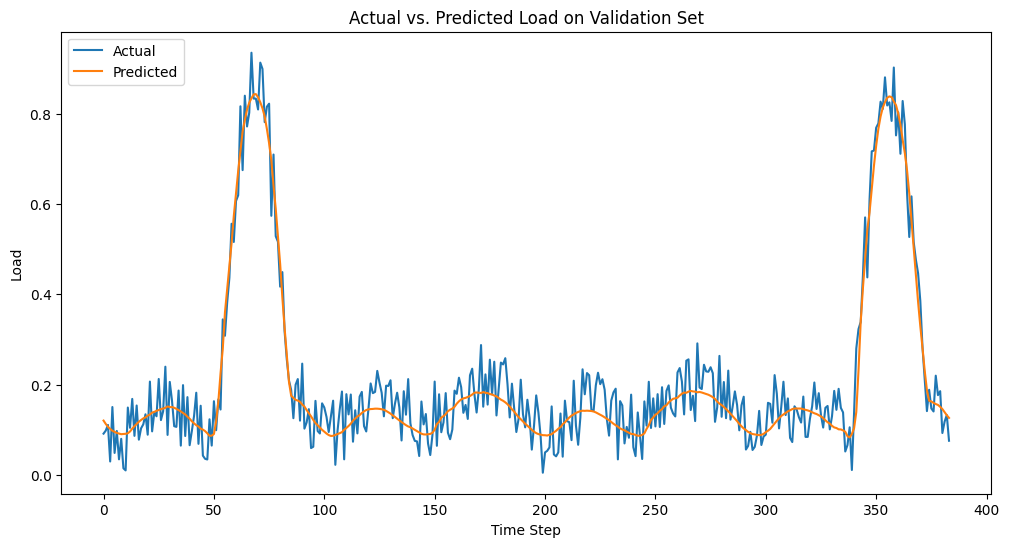

In [12]:
# 可视化预测值和实际值
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_values.flatten()[:96*4], label='Actual')
plt.plot(predictions.flatten()[:96*4], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.title('Actual vs. Predicted Load on Validation Set')
plt.show()

In [13]:
for name, param in model.named_parameters():
        print(f"Name: {name}, Shape: {param.shape}, Gradient Required: {param.requires_grad}")

Name: encoder.weight_ih_l0, Shape: torch.Size([384, 4]), Gradient Required: True
Name: encoder.weight_hh_l0, Shape: torch.Size([384, 128]), Gradient Required: True
Name: encoder.bias_ih_l0, Shape: torch.Size([384]), Gradient Required: True
Name: encoder.bias_hh_l0, Shape: torch.Size([384]), Gradient Required: True
Name: encoder.weight_ih_l0_reverse, Shape: torch.Size([384, 4]), Gradient Required: True
Name: encoder.weight_hh_l0_reverse, Shape: torch.Size([384, 128]), Gradient Required: True
Name: encoder.bias_ih_l0_reverse, Shape: torch.Size([384]), Gradient Required: True
Name: encoder.bias_hh_l0_reverse, Shape: torch.Size([384]), Gradient Required: True
Name: encoder.weight_ih_l1, Shape: torch.Size([384, 256]), Gradient Required: True
Name: encoder.weight_hh_l1, Shape: torch.Size([384, 128]), Gradient Required: True
Name: encoder.bias_ih_l1, Shape: torch.Size([384]), Gradient Required: True
Name: encoder.bias_hh_l1, Shape: torch.Size([384]), Gradient Required: True
Name: encoder.weig